In [1]:
import os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

# Order book data EDA

In [2]:
path = r'./book_train.parquet/stock_id=0'


def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

def order_book_data_feature_construction(path):

    stock_id = path.split("=")[1]
    example_book_df = pd.read_parquet(path)

    # construct item for realized volatility calculation
    example_book_df.loc[:,('ask_spread')] = example_book_df['ask_size1'] - example_book_df['ask_size2']
    example_book_df.loc[:,('bid_spread')] = example_book_df['bid_size1'] - example_book_df['bid_size2']
    example_book_df.loc[:,('total_volume')] = example_book_df['ask_size1'] + example_book_df['ask_size2'] + example_book_df['bid_size1'] + example_book_df['bid_size2']
    example_book_df.loc[:,('volume_imbalance')] = abs(example_book_df['ask_size1'] + example_book_df['ask_size2'] - example_book_df['bid_size1'] - example_book_df['bid_size2'] )


    example_book_df.loc[:,('price_spread')] = (example_book_df['ask_price1']/example_book_df['bid_price1'])-1 # Constrcut Bid/Ask Spread.
    example_book_df.loc[:,('wap1')] = (example_book_df['bid_price1']*example_book_df['ask_size1'] + example_book_df['ask_price1']*example_book_df['bid_size1']) / (example_book_df['ask_size1'] + example_book_df['bid_size1'])
    example_book_df.loc[:,('wap2')] = (example_book_df['bid_price2']*example_book_df['ask_size2'] + example_book_df['ask_price2']*example_book_df['bid_size2']) / (example_book_df['ask_size2'] + example_book_df['bid_size2'])
    example_book_df.loc[:,('wap_balance')] = example_book_df['wap1'] - example_book_df['wap2']

    example_book_df.loc[:,('log_return1')] = example_book_df.groupby('time_id')['wap1'].apply(log_return)
    example_book_df.loc[:,('log_return2')] = example_book_df.groupby('time_id')['wap2'].apply(log_return)
    example_book_df = example_book_df[~example_book_df['log_return1'].isnull()] # drop the first null return value

    return example_book_df

example_book_df = order_book_data_feature_construction(path)
example_book_df

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,ask_spread,bid_spread,total_volume,volume_imbalance,price_spread,wap1,wap2,wap_balance,log_return1,log_return2
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,0,1,205,195,0.000878,1.001448,1.001390,0.000058,0.000014,0.000000
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100,0,1,205,195,0.000878,1.001448,1.001391,0.000057,0.000000,0.000001
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100,26,1,231,221,0.000878,1.001443,1.001391,0.000052,-0.000005,0.000000
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100,26,1,231,221,0.000878,1.001443,1.001391,0.000052,0.000000,0.000000
5,5,11,1.001422,1.002301,1.001370,1.002405,3,100,2,100,0,1,205,195,0.000878,1.001448,1.001391,0.000057,0.000005,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
917548,32767,568,0.998275,0.998754,0.997796,0.998946,90,90,48,28,62,42,256,20,0.000480,0.998515,0.998522,-0.000008,0.000434,-0.000162
917549,32767,569,0.998275,0.998754,0.997892,0.998946,91,90,200,28,62,-109,409,173,0.000480,0.998516,0.998817,-0.000300,0.000001,0.000295
917550,32767,571,0.998275,0.998754,0.997892,0.998946,91,90,100,28,62,-9,309,73,0.000480,0.998516,0.998715,-0.000199,0.000000,-0.000101
917551,32767,572,0.998275,0.998754,0.997892,0.998946,92,90,100,28,62,-8,310,74,0.000480,0.998517,0.998715,-0.000198,0.000001,0.000000


In [3]:
create_feature_dict = {
        'log_return1':[realized_volatility],
        'log_return2':[realized_volatility],
        'wap_balance':[np.mean,],
        'price_spread':[np.mean],
        'bid_spread':[np.mean],
        'ask_spread':[np.mean],
        'volume_imbalance':[np.mean],
        'total_volume':[np.mean],
        'wap1':[np.mean],
        'wap2':[np.mean],
            }

df_feature = pd.DataFrame(example_book_df.groupby(['time_id']).agg(create_feature_dict)).reset_index()
df_feature.columns = ['_'.join(col) for col in df_feature.columns]

df_feature 

,time_id_,log_return1_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap1_mean,wap2_mean
0,5,0.004499,0.006999,0.000065,0.000852,-2.627907,-15.661130,134.275748,323.471761,1.003733,1.003668
1,11,0.001204,0.002476,0.000032,0.000393,53.864322,-24.221106,142.286432,411.733668,1.000240,1.000208
2,16,0.002369,0.004801,-0.000141,0.000725,-18.417112,57.807487,140.267380,416.310160,0.999541,0.999682
3,31,0.002574,0.003637,0.000195,0.000863,43.218487,-9.319328,147.394958,433.126050,0.998819,0.998624
4,62,0.001894,0.003257,-0.000008,0.000396,31.931429,41.668571,124.011429,344.457143,0.999616,0.999624
...,...,...,...,...,...,...,...,...,...,...,...
3825,32751,0.002579,0.003821,0.000074,0.000553,49.608108,-25.956081,197.179054,374.733108,0.997936,0.997862
3826,32753,0.002206,0.002847,-0.000179,0.000543,-44.009756,107.297561,234.136585,621.424390,1.000312,1.000491
3827,32758,0.002913,0.003266,0.000094,0.000523,15.652406,-3.160428,116.449198,342.363636,0.999556,0.999462
3828,32763,0.003046,0.005105,-0.000029,0.000481,8.480392,-0.506536,132.241830,386.274510,1.002360,1.002389


- In usual financial market, we know trading volume is high in both opening hour and closing hour compare to other timing periods.

  Therefore, it might make sense to split the seconds in bucket and construct features

- First lets' see how many seconds in each time_id. 

  From the below plot, it make sense to split the seconds in bucket to >=150, >=300, >=450.

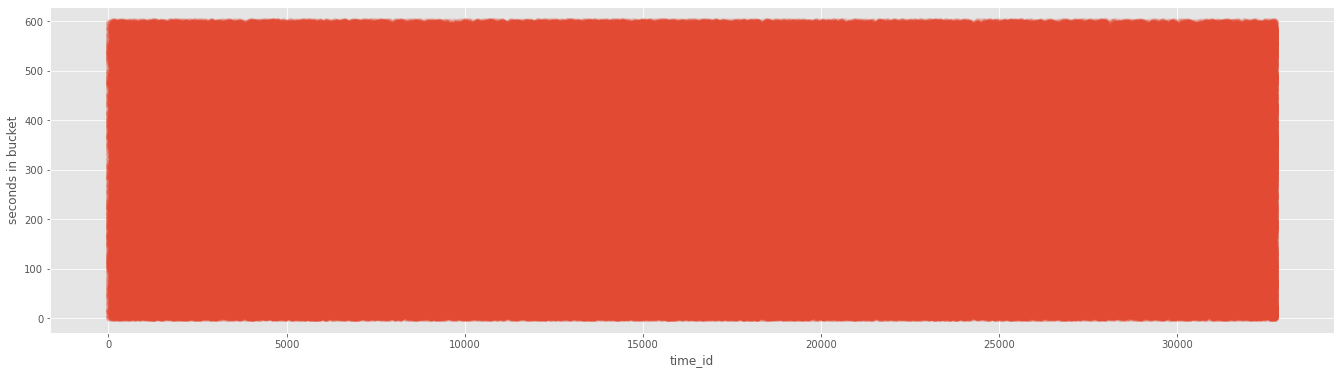

In [4]:
fig, ax = plt.subplots(figsize=(23,6))
ax.scatter(example_book_df['time_id'],example_book_df['seconds_in_bucket'],alpha=0.1)
ax.set_xlabel('time_id')
ax.set_ylabel('seconds in bucket')
plt.show()

In [5]:
seconds_in_bucket_interval = 150
times_interval = 0

for interval in range(3):

    times_interval += seconds_in_bucket_interval
    print(times_interval)

150
300
450


In [6]:
df_book_feature = pd.DataFrame()
seconds_in_bucket_interval = 150
times_interval = 0

for interval in range(3):

    times_interval += seconds_in_bucket_interval
    
    df_feature_sec = pd.DataFrame(example_book_df.query(f'seconds_in_bucket >= {times_interval}').groupby(['time_id']).agg(create_feature_dict)).reset_index()
    df_feature_sec.columns = ['_'.join(col) + "_" + str(times_interval) for col in df_feature_sec.columns]
    df_feature_sec.columns = df_feature_sec.columns.str.replace('time_id__'+str(times_interval), 'time_id')

    if interval == 0:
        df_book_feature = df_feature_sec
    else:
        df_book_feature = pd.merge(df_book_feature,df_feature_sec,how='left',left_on='time_id',right_on='time_id')


print(df_book_feature.columns)
df_book_feature

Index(['time_id', 'log_return1_realized_volatility_150',
       'log_return2_realized_volatility_150', 'wap_balance_mean_150',
       'price_spread_mean_150', 'bid_spread_mean_150', 'ask_spread_mean_150',
       'volume_imbalance_mean_150', 'total_volume_mean_150', 'wap1_mean_150',
       'wap2_mean_150', 'log_return1_realized_volatility_300',
       'log_return2_realized_volatility_300', 'wap_balance_mean_300',
       'price_spread_mean_300', 'bid_spread_mean_300', 'ask_spread_mean_300',
       'volume_imbalance_mean_300', 'total_volume_mean_300', 'wap1_mean_300',
       'wap2_mean_300', 'log_return1_realized_volatility_450',
       'log_return2_realized_volatility_450', 'wap_balance_mean_450',
       'price_spread_mean_450', 'bid_spread_mean_450', 'ask_spread_mean_450',
       'volume_imbalance_mean_450', 'total_volume_mean_450', 'wap1_mean_450',
       'wap2_mean_450'],
      dtype='object')


,time_id,log_return1_realized_volatility_150,log_return2_realized_volatility_150,wap_balance_mean_150,price_spread_mean_150,bid_spread_mean_150,ask_spread_mean_150,volume_imbalance_mean_150,total_volume_mean_150,wap1_mean_150,...,log_return1_realized_volatility_450,log_return2_realized_volatility_450,wap_balance_mean_450,price_spread_mean_450,bid_spread_mean_450,ask_spread_mean_450,volume_imbalance_mean_450,total_volume_mean_450,wap1_mean_450,wap2_mean_450
0,5,0.003796,0.006087,0.000078,0.000858,-1.900862,-15.926724,123.586207,327.431034,1.003832,...,0.001721,0.004114,0.000075,0.000783,-11.823529,-18.705882,141.470588,263.941176,1.003482,1.003407
1,11,0.001058,0.002262,0.000056,0.000353,64.722543,-30.381503,151.566474,419.277457,1.000301,...,0.000918,0.001883,0.000120,0.000348,58.685185,-56.555556,97.685185,447.981481,1.000518,1.000399
2,16,0.002138,0.004019,-0.000186,0.000679,-27.386555,87.033613,132.084034,428.537815,0.999126,...,0.001158,0.002972,-0.000244,0.000605,-47.818182,104.022727,156.113636,459.113636,0.998237,0.998481
3,31,0.002196,0.003273,0.000111,0.000921,23.654321,17.049383,151.765432,424.234568,0.998464,...,0.000993,0.001424,-0.000345,0.001059,-80.444444,123.777778,146.000000,540.000000,0.998079,0.998424
4,62,0.001609,0.002927,-0.000052,0.000395,19.637037,50.370370,131.474074,371.266667,0.999618,...,0.001378,0.000966,-0.000255,0.000520,-120.277778,59.277778,117.000000,391.944444,0.999518,0.999773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,32751,0.002383,0.003507,0.000117,0.000573,54.127753,-44.960352,196.365639,349.916300,0.997784,...,0.001148,0.002048,0.000071,0.000425,58.076923,7.846154,227.153846,322.200000,0.996724,0.996653
3826,32753,0.001519,0.002396,-0.000214,0.000577,-27.945578,145.360544,253.850340,707.782313,1.000528,...,0.001146,0.001863,-0.000175,0.000572,14.804348,180.413043,234.217391,531.478261,1.000614,1.000789
3827,32758,0.002404,0.003006,0.000062,0.000515,17.804511,19.443609,103.022556,313.142857,0.999855,...,0.001303,0.001972,0.000151,0.000470,49.370968,-12.935484,120.048387,331.177419,1.000342,1.000191
3828,32763,0.002645,0.004526,-0.000044,0.000518,12.205479,13.707763,120.972603,389.273973,1.002281,...,0.001413,0.002180,0.000087,0.000519,50.723684,18.407895,121.394737,451.684211,1.002322,1.002234


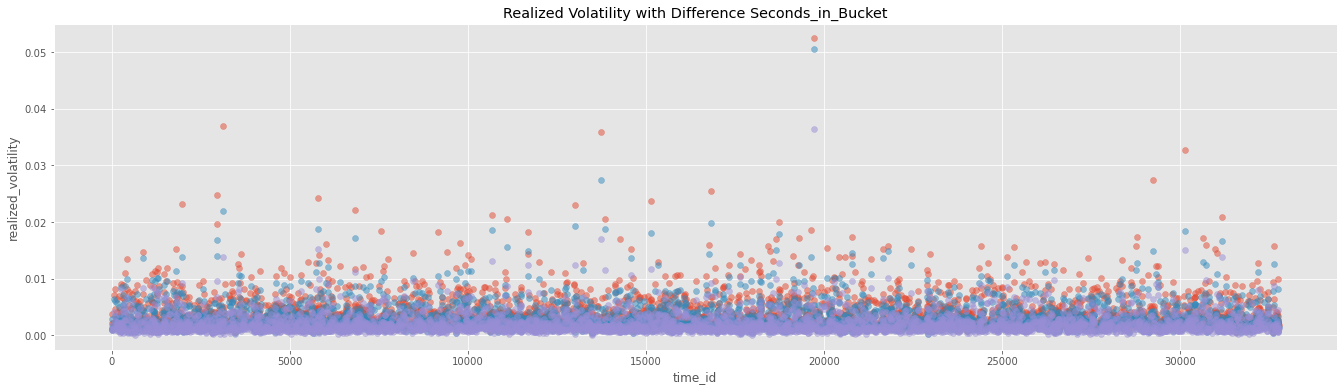

In [9]:
fig,ax = plt.subplots(figsize=(23,6))
ax.set_title('Realized Volatility with Difference Seconds_in_Bucket')
ax.scatter(df_book_feature['time_id'],df_book_feature['log_return1_realized_volatility_150'],alpha=0.5)
ax.scatter(df_book_feature['time_id'],df_book_feature['log_return1_realized_volatility_300'],alpha=0.5)
ax.scatter(df_book_feature['time_id'],df_book_feature['log_return1_realized_volatility_450'],alpha=0.5)
ax.set_xlabel('time_id')
ax.set_ylabel('realized_volatility')
plt.show()

# Trade book data EDA

In [10]:
example_trade_book_df = pd.read_parquet(r'trade_train.parquet/stock_id=1/170b39f1f7144bb3b4554aabc336106e.parquet')
example_trade_book_df.columns = ['time_id','seconds_in_bucket','trade_price','trade_size','trade_order_count']
example_trade_book_df

,time_id,seconds_in_bucket,trade_price,trade_size,trade_order_count
0,5,28,1.002080,553,11
1,5,39,1.002460,8,3
2,5,42,1.002308,147,4
3,5,44,1.002788,1,1
4,5,51,1.002657,100,2
...,...,...,...,...,...
296205,32767,579,0.999010,81,3
296206,32767,587,0.999109,50,1
296207,32767,588,0.999010,126,2
296208,32767,592,0.999109,1,1


In [11]:
example_trade_book_df.loc[:,('trade_per_size')] = example_trade_book_df['trade_size'] / example_trade_book_df['trade_order_count']
example_trade_book_df.loc[:,('trade_log_return')] = example_trade_book_df.groupby('time_id')['trade_price'].apply(log_return)
example_trade_book_df = example_trade_book_df[~example_trade_book_df['trade_log_return'].isnull()] # drop the first null return value
example_trade_book_df

,time_id,seconds_in_bucket,trade_price,trade_size,trade_order_count,trade_per_size,trade_log_return
1,5,39,1.002460,8,3,2.666667,0.000379
2,5,42,1.002308,147,4,36.750000,-0.000152
3,5,44,1.002788,1,1,1.000000,0.000479
4,5,51,1.002657,100,2,50.000000,-0.000131
5,5,52,1.002723,20,1,20.000000,0.000066
...,...,...,...,...,...,...,...
296205,32767,579,0.999010,81,3,27.000000,-0.000087
296206,32767,587,0.999109,50,1,50.000000,0.000099
296207,32767,588,0.999010,126,2,63.000000,-0.000099
296208,32767,592,0.999109,1,1,1.000000,0.000099


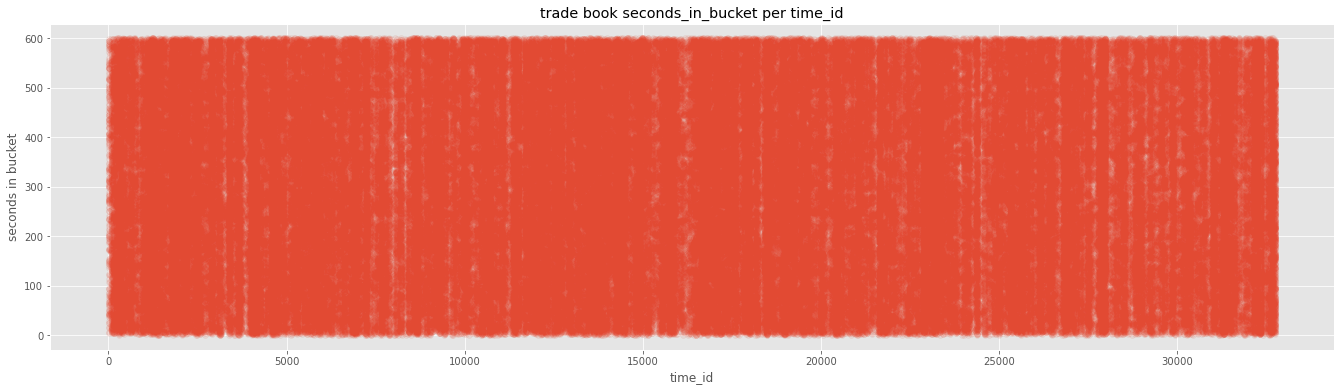

In [12]:
fig, ax = plt.subplots(figsize=(23,6))
ax.set_title('trade book seconds_in_bucket per time_id')
ax.scatter(example_trade_book_df['time_id'],example_trade_book_df['seconds_in_bucket'],alpha=0.1)
ax.set_xlabel('time_id')
ax.set_ylabel('seconds in bucket')
plt.show()

In [13]:
create_trade_book_feature_dict = {
        'trade_log_return':[realized_volatility],
        'trade_per_size':[np.mean],
        'trade_price':[np.mean],
        'trade_order_count':[np.mean],
        'trade_size':[np.mean],
            }

df_trade_feature = pd.DataFrame(example_trade_book_df.groupby(['time_id']).agg(create_trade_book_feature_dict)).reset_index()
df_trade_feature.columns = ['_'.join(col) for col in df_trade_feature.columns]

df_trade_feature 

,time_id_,trade_log_return_realized_volatility,trade_per_size_mean,trade_price_mean,trade_order_count_mean,trade_size_mean
0,5,0.003087,24.749878,1.003758,3.236559,101.666667
1,11,0.001700,26.015476,1.001911,2.795918,85.326531
2,16,0.001922,57.139408,1.001150,2.716049,135.802469
3,31,0.001735,19.532887,0.997576,2.281250,61.906250
4,62,0.001666,18.972222,1.000811,1.875000,44.250000
...,...,...,...,...,...,...
3825,32751,0.001776,16.449578,1.000115,2.750000,66.895833
3826,32753,0.008492,52.463125,1.008155,7.912088,416.939560
3827,32758,0.001927,41.424667,1.000836,2.680000,85.560000
3828,32763,0.002856,50.895385,1.003162,2.907407,152.296296


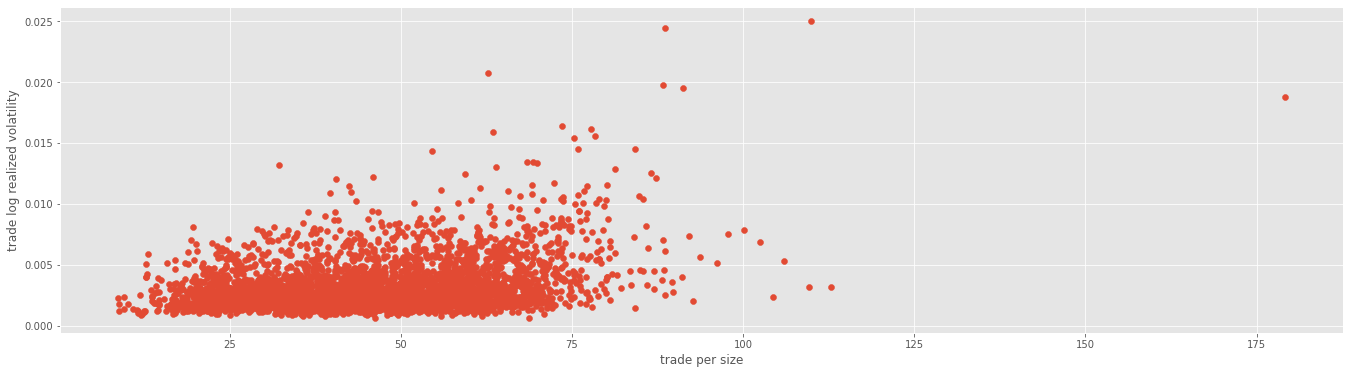

In [14]:
fig,ax = plt.subplots(figsize=(23,6))
ax.scatter(df_trade_feature['trade_per_size_mean'],df_trade_feature['trade_log_return_realized_volatility'])
ax.set_xlabel('trade per size')
ax.set_ylabel('trade log realized volatility')
plt.show()

In [15]:
df_trade_feature = pd.DataFrame()
seconds_in_bucket_interval = 150
times_interval = 0

for interval in range(3):

    times_interval += seconds_in_bucket_interval
    
    df_trade_feature_sec = pd.DataFrame(example_trade_book_df.query(f'seconds_in_bucket >= {times_interval}').groupby(['time_id']).agg(create_trade_book_feature_dict)).reset_index()
    df_trade_feature_sec.columns = ['_'.join(col) + "_" + str(times_interval) for col in df_trade_feature_sec.columns]
    df_trade_feature_sec.columns = df_trade_feature_sec.columns.str.replace('time_id__'+str(times_interval), 'time_id')

    if interval == 0:
        df_trade_feature = df_trade_feature_sec
    else:
        df_trade_feature = pd.merge(df_trade_feature,df_trade_feature_sec,how='left',left_on='time_id',right_on='time_id')


print(df_trade_feature.columns)
df_trade_feature

Index(['time_id', 'trade_log_return_realized_volatility_150',
       'trade_per_size_mean_150', 'trade_price_mean_150',
       'trade_order_count_mean_150', 'trade_size_mean_150',
       'trade_log_return_realized_volatility_300', 'trade_per_size_mean_300',
       'trade_price_mean_300', 'trade_order_count_mean_300',
       'trade_size_mean_300', 'trade_log_return_realized_volatility_450',
       'trade_per_size_mean_450', 'trade_price_mean_450',
       'trade_order_count_mean_450', 'trade_size_mean_450'],
      dtype='object')


,time_id,trade_log_return_realized_volatility_150,trade_per_size_mean_150,trade_price_mean_150,trade_order_count_mean_150,trade_size_mean_150,trade_log_return_realized_volatility_300,trade_per_size_mean_300,trade_price_mean_300,trade_order_count_mean_300,trade_size_mean_300,trade_log_return_realized_volatility_450,trade_per_size_mean_450,trade_price_mean_450,trade_order_count_mean_450,trade_size_mean_450
0,5,0.002754,25.646019,1.004001,3.141026,94.923077,0.002130,20.567711,1.003527,3.244898,64.551020,0.001451,15.553788,1.003386,3.500000,64.590909
1,11,0.001504,20.901126,1.001950,2.648649,73.891892,0.001159,20.829167,1.002051,2.857143,77.392857,0.000802,24.951852,1.002018,3.000000,103.333333
2,16,0.001723,54.621750,1.001491,2.968750,144.859375,0.001625,57.598016,1.001670,2.880000,151.280000,0.000925,67.455357,1.001749,2.642857,170.000000
3,31,0.001328,20.320563,0.997234,2.636364,73.681818,0.001165,25.200000,0.996926,2.769231,81.538462,0.000871,25.100000,0.996921,2.818182,77.909091
4,62,0.001634,22.105263,1.000884,2.000000,53.263158,0.001168,15.904762,1.000801,1.857143,42.428571,0.000658,19.111111,1.000862,1.833333,47.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,32751,0.001585,18.245271,1.000110,3.027778,74.805556,0.001280,20.530642,1.000165,3.608696,82.130435,0.000890,18.304563,1.000193,3.333333,66.916667
3826,32753,0.007915,48.761134,1.010687,8.586207,427.889655,0.006310,44.155094,1.012523,8.136364,350.659091,0.003531,47.760807,1.011895,6.410256,354.589744
3827,32758,0.001804,39.767460,1.001051,2.666667,82.761905,0.001567,41.737879,1.001213,2.727273,89.090909,0.001134,42.733333,1.001219,2.400000,97.400000
3828,32763,0.002557,49.971283,1.003785,2.643678,140.666667,0.001919,51.322710,1.004327,2.701754,145.157895,0.001494,48.529514,1.004053,2.656250,138.343750


# Join Features DataFrame

In [16]:
join_book_df = pd.merge(df_book_feature,df_trade_feature,left_on=['time_id'],right_on=['time_id'],how='left').fillna(value=0)
join_book_df

,time_id,log_return1_realized_volatility_150,log_return2_realized_volatility_150,wap_balance_mean_150,price_spread_mean_150,bid_spread_mean_150,ask_spread_mean_150,volume_imbalance_mean_150,total_volume_mean_150,wap1_mean_150,...,trade_log_return_realized_volatility_300,trade_per_size_mean_300,trade_price_mean_300,trade_order_count_mean_300,trade_size_mean_300,trade_log_return_realized_volatility_450,trade_per_size_mean_450,trade_price_mean_450,trade_order_count_mean_450,trade_size_mean_450
0,5,0.003796,0.006087,0.000078,0.000858,-1.900862,-15.926724,123.586207,327.431034,1.003832,...,0.002130,20.567711,1.003527,3.244898,64.551020,0.001451,15.553788,1.003386,3.500000,64.590909
1,11,0.001058,0.002262,0.000056,0.000353,64.722543,-30.381503,151.566474,419.277457,1.000301,...,0.001159,20.829167,1.002051,2.857143,77.392857,0.000802,24.951852,1.002018,3.000000,103.333333
2,16,0.002138,0.004019,-0.000186,0.000679,-27.386555,87.033613,132.084034,428.537815,0.999126,...,0.001625,57.598016,1.001670,2.880000,151.280000,0.000925,67.455357,1.001749,2.642857,170.000000
3,31,0.002196,0.003273,0.000111,0.000921,23.654321,17.049383,151.765432,424.234568,0.998464,...,0.001165,25.200000,0.996926,2.769231,81.538462,0.000871,25.100000,0.996921,2.818182,77.909091
4,62,0.001609,0.002927,-0.000052,0.000395,19.637037,50.370370,131.474074,371.266667,0.999618,...,0.001168,15.904762,1.000801,1.857143,42.428571,0.000658,19.111111,1.000862,1.833333,47.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,32751,0.002383,0.003507,0.000117,0.000573,54.127753,-44.960352,196.365639,349.916300,0.997784,...,0.001280,20.530642,1.000165,3.608696,82.130435,0.000890,18.304563,1.000193,3.333333,66.916667
3826,32753,0.001519,0.002396,-0.000214,0.000577,-27.945578,145.360544,253.850340,707.782313,1.000528,...,0.006310,44.155094,1.012523,8.136364,350.659091,0.003531,47.760807,1.011895,6.410256,354.589744
3827,32758,0.002404,0.003006,0.000062,0.000515,17.804511,19.443609,103.022556,313.142857,0.999855,...,0.001567,41.737879,1.001213,2.727273,89.090909,0.001134,42.733333,1.001219,2.400000,97.400000
3828,32763,0.002645,0.004526,-0.000044,0.000518,12.205479,13.707763,120.972603,389.273973,1.002281,...,0.001919,51.322710,1.004327,2.701754,145.157895,0.001494,48.529514,1.004053,2.656250,138.343750


# Function and pipeline all the process

- book data

In [17]:
path = r'./book_train.parquet/stock_id=0'


def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

def order_book_data_feature_construction(path):

    stock_id = path.split("=")[1]
    example_book_df = pd.read_parquet(path)

    # construct item for realized volatility calculation
    example_book_df.loc[:,('ask_spread')] = example_book_df['ask_size1'] - example_book_df['ask_size2']
    example_book_df.loc[:,('bid_spread')] = example_book_df['bid_size1'] - example_book_df['bid_size2']
    example_book_df.loc[:,('total_volume')] = example_book_df['ask_size1'] + example_book_df['ask_size2'] + example_book_df['bid_size1'] + example_book_df['bid_size2']
    example_book_df.loc[:,('volume_imbalance')] = abs(example_book_df['ask_size1'] + example_book_df['ask_size2'] - example_book_df['bid_size1'] - example_book_df['bid_size2'] )


    example_book_df.loc[:,('price_spread')] = (example_book_df['ask_price1']/example_book_df['bid_price1'])-1 # Constrcut Bid/Ask Spread.
    example_book_df.loc[:,('wap1')] = (example_book_df['bid_price1']*example_book_df['ask_size1'] + example_book_df['ask_price1']*example_book_df['bid_size1']) / (example_book_df['ask_size1'] + example_book_df['bid_size1'])
    example_book_df.loc[:,('wap2')] = (example_book_df['bid_price2']*example_book_df['ask_size2'] + example_book_df['ask_price2']*example_book_df['bid_size2']) / (example_book_df['ask_size2'] + example_book_df['bid_size2'])
    example_book_df.loc[:,('wap_balance')] = example_book_df['wap1'] - example_book_df['wap2']

    example_book_df.loc[:,('log_return1')] = example_book_df.groupby('time_id')['wap1'].apply(log_return)
    example_book_df.loc[:,('log_return2')] = example_book_df.groupby('time_id')['wap2'].apply(log_return)
    example_book_df = example_book_df[~example_book_df['log_return1'].isnull()] # drop the first null return value

    return example_book_df


def book_data_preprocess_per_stock(path):

    stock_id = path.split("=")[1]
    example_book_df = order_book_data_feature_construction(path)

    create_feature_dict = {
            'log_return1':[realized_volatility],
            'log_return2':[realized_volatility],
            'wap_balance':[np.mean,],
            'price_spread':[np.mean],
            'bid_spread':[np.mean],
            'ask_spread':[np.mean],
            'volume_imbalance':[np.mean],
            'total_volume':[np.mean],
            'wap1':[np.mean],
            'wap2':[np.mean],
                }

    df_feature = pd.DataFrame(example_book_df.groupby(['time_id']).agg(create_feature_dict)).reset_index()
    df_feature.columns = ['_'.join(col) for col in df_feature.columns]

    df_book_feature = pd.DataFrame()
    seconds_in_bucket_interval = 150
    times_interval = 0

    for interval in range(3):

        times_interval += seconds_in_bucket_interval
        
        df_feature_sec = pd.DataFrame(example_book_df.query(f'seconds_in_bucket >= {times_interval}').groupby(['time_id']).agg(create_feature_dict)).reset_index()
        df_feature_sec.columns = ['_'.join(col) + "_" + str(times_interval) for col in df_feature_sec.columns]
        df_feature_sec.columns = df_feature_sec.columns.str.replace('time_id__'+str(times_interval), 'time_id')

        if interval == 0:
            df_book_feature = df_feature_sec
        else:
            df_book_feature = pd.merge(df_book_feature,df_feature_sec,how='left',left_on='time_id',right_on='time_id')

    df_book_feature.insert(0,'row_id' ,[f'{stock_id}-{x}' for x in df_book_feature['time_id'].to_list()])
    df_book_feature = df_book_feature.drop(['time_id'],axis=1)

    return df_book_feature


book_data_preprocess_per_stock(path)

,row_id,log_return1_realized_volatility_150,log_return2_realized_volatility_150,wap_balance_mean_150,price_spread_mean_150,bid_spread_mean_150,ask_spread_mean_150,volume_imbalance_mean_150,total_volume_mean_150,wap1_mean_150,...,log_return1_realized_volatility_450,log_return2_realized_volatility_450,wap_balance_mean_450,price_spread_mean_450,bid_spread_mean_450,ask_spread_mean_450,volume_imbalance_mean_450,total_volume_mean_450,wap1_mean_450,wap2_mean_450
0,0-5,0.003796,0.006087,0.000078,0.000858,-1.900862,-15.926724,123.586207,327.431034,1.003832,...,0.001721,0.004114,0.000075,0.000783,-11.823529,-18.705882,141.470588,263.941176,1.003482,1.003407
1,0-11,0.001058,0.002262,0.000056,0.000353,64.722543,-30.381503,151.566474,419.277457,1.000301,...,0.000918,0.001883,0.000120,0.000348,58.685185,-56.555556,97.685185,447.981481,1.000518,1.000399
2,0-16,0.002138,0.004019,-0.000186,0.000679,-27.386555,87.033613,132.084034,428.537815,0.999126,...,0.001158,0.002972,-0.000244,0.000605,-47.818182,104.022727,156.113636,459.113636,0.998237,0.998481
3,0-31,0.002196,0.003273,0.000111,0.000921,23.654321,17.049383,151.765432,424.234568,0.998464,...,0.000993,0.001424,-0.000345,0.001059,-80.444444,123.777778,146.000000,540.000000,0.998079,0.998424
4,0-62,0.001609,0.002927,-0.000052,0.000395,19.637037,50.370370,131.474074,371.266667,0.999618,...,0.001378,0.000966,-0.000255,0.000520,-120.277778,59.277778,117.000000,391.944444,0.999518,0.999773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,0-32751,0.002383,0.003507,0.000117,0.000573,54.127753,-44.960352,196.365639,349.916300,0.997784,...,0.001148,0.002048,0.000071,0.000425,58.076923,7.846154,227.153846,322.200000,0.996724,0.996653
3826,0-32753,0.001519,0.002396,-0.000214,0.000577,-27.945578,145.360544,253.850340,707.782313,1.000528,...,0.001146,0.001863,-0.000175,0.000572,14.804348,180.413043,234.217391,531.478261,1.000614,1.000789
3827,0-32758,0.002404,0.003006,0.000062,0.000515,17.804511,19.443609,103.022556,313.142857,0.999855,...,0.001303,0.001972,0.000151,0.000470,49.370968,-12.935484,120.048387,331.177419,1.000342,1.000191
3828,0-32763,0.002645,0.004526,-0.000044,0.000518,12.205479,13.707763,120.972603,389.273973,1.002281,...,0.001413,0.002180,0.000087,0.000519,50.723684,18.407895,121.394737,451.684211,1.002322,1.002234


- trade data

In [18]:
trade_path = r'trade_train.parquet/stock_id=0'

def trade_book_data_feature_construction(path):

    example_trade_book_df = pd.read_parquet(path)
    example_trade_book_df.columns = ['time_id','seconds_in_bucket','trade_price','trade_size','trade_order_count']


    example_trade_book_df.loc[:,('trade_per_size')] = example_trade_book_df['trade_size'] / example_trade_book_df['trade_order_count']
    example_trade_book_df.loc[:,('trade_log_return')] = example_trade_book_df.groupby('time_id')['trade_price'].apply(log_return)
    example_trade_book_df = example_trade_book_df[~example_trade_book_df['trade_log_return'].isnull()] # drop the first null return value

    return example_trade_book_df


def trade_data_preprocess_per_stock(path):

    stock_id = path.split("=")[1]
    example_trade_book_df = trade_book_data_feature_construction(path)

    create_trade_book_feature_dict = {
            'trade_log_return':[realized_volatility],
            'trade_per_size':[np.mean],
            'trade_price':[np.mean],
            'trade_order_count':[np.mean],
            'trade_size':[np.mean],
                }

    df_trade_feature = pd.DataFrame(example_trade_book_df.groupby(['time_id']).agg(create_trade_book_feature_dict)).reset_index()
    df_trade_feature.columns = ['_'.join(col) for col in df_trade_feature.columns]

    df_trade_feature = pd.DataFrame()
    seconds_in_bucket_interval = 150
    times_interval = 0

    for interval in range(3):

        times_interval += seconds_in_bucket_interval
        
        df_trade_feature_sec = pd.DataFrame(example_trade_book_df.query(f'seconds_in_bucket >= {times_interval}').groupby(['time_id']).agg(create_trade_book_feature_dict)).reset_index()
        df_trade_feature_sec.columns = ['_'.join(col) + "_" + str(times_interval) for col in df_trade_feature_sec.columns]
        df_trade_feature_sec.columns = df_trade_feature_sec.columns.str.replace('time_id__'+str(times_interval), 'time_id')

        if interval == 0:
            df_trade_feature = df_trade_feature_sec
        else:
            df_trade_feature = pd.merge(df_trade_feature,df_trade_feature_sec,how='left',left_on='time_id',right_on='time_id')

    df_trade_feature.insert(0,'row_id' ,[f'{stock_id}-{x}' for x in df_trade_feature['time_id'].to_list()])
    df_trade_feature = df_trade_feature.drop(['time_id'],axis=1)

    return df_trade_feature

trade_data_preprocess_per_stock(trade_path)

,row_id,trade_log_return_realized_volatility_150,trade_per_size_mean_150,trade_price_mean_150,trade_order_count_mean_150,trade_size_mean_150,trade_log_return_realized_volatility_300,trade_per_size_mean_300,trade_price_mean_300,trade_order_count_mean_300,trade_size_mean_300,trade_log_return_realized_volatility_450,trade_per_size_mean_450,trade_price_mean_450,trade_order_count_mean_450,trade_size_mean_450
0,0-5,0.001701,21.876825,1.003777,2.433333,68.966667,0.001308,18.628798,1.003679,2.571429,75.571429,0.001060,16.764626,1.003417,2.642857,74.428571
1,0-11,0.000813,22.576389,1.000285,2.041667,48.875000,0.000587,26.822917,1.000392,2.250000,56.250000,0.000501,39.966667,1.000488,2.200000,82.800000
2,0-16,0.001621,29.298095,0.998961,2.950000,100.500000,0.001137,27.236111,0.998508,3.166667,99.083333,0.001048,32.240741,0.998130,3.666667,120.555556
3,0-31,0.001401,30.904040,0.998712,4.545455,148.272727,0.001089,34.623457,0.998780,5.111111,172.888889,0.000802,30.250000,0.998106,3.666667,171.333333
4,0-62,0.000550,17.663848,0.999625,4.500000,98.125000,0.000453,19.656506,0.999555,4.909091,110.818182,0.000360,2.725000,0.999547,3.500000,10.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3824,0-32751,0.001409,18.834146,0.997368,3.238095,70.404762,0.001162,19.163118,0.997196,3.257143,67.571429,0.000786,25.039912,0.996757,2.947368,61.000000
3825,0-32753,0.001284,24.024123,1.000564,3.421053,131.263158,0.001066,33.454861,1.000721,4.250000,180.083333,0.000750,35.733333,1.000757,4.600000,231.600000
3826,0-32758,0.001375,32.458866,0.999899,3.444444,101.333333,0.001242,32.324518,1.000083,3.727273,104.272727,0.000780,29.437500,1.000482,2.000000,52.000000
3827,0-32763,0.001650,29.478009,1.002237,2.055556,63.777778,0.001404,33.391667,1.002254,1.920000,65.080000,0.001012,53.649306,1.002340,2.666667,117.916667


In [19]:
def main_data_preprocess(book_path,trade_path):

    df_book_features = book_data_preprocess_per_stock(book_path)
    df_trade_features = trade_data_preprocess_per_stock(trade_path)

    return pd.merge(df_book_features,df_trade_features,how='left',left_on='row_id',right_on='row_id')


book_path = r'./book_train.parquet/stock_id=0'
trade_path = r'trade_train.parquet/stock_id=0'


feature_per_stock = main_data_preprocess(book_path,trade_path)
feature_per_stock

,row_id,log_return1_realized_volatility_150,log_return2_realized_volatility_150,wap_balance_mean_150,price_spread_mean_150,bid_spread_mean_150,ask_spread_mean_150,volume_imbalance_mean_150,total_volume_mean_150,wap1_mean_150,...,trade_log_return_realized_volatility_300,trade_per_size_mean_300,trade_price_mean_300,trade_order_count_mean_300,trade_size_mean_300,trade_log_return_realized_volatility_450,trade_per_size_mean_450,trade_price_mean_450,trade_order_count_mean_450,trade_size_mean_450
0,0-5,0.003796,0.006087,0.000078,0.000858,-1.900862,-15.926724,123.586207,327.431034,1.003832,...,0.001308,18.628798,1.003679,2.571429,75.571429,0.001060,16.764626,1.003417,2.642857,74.428571
1,0-11,0.001058,0.002262,0.000056,0.000353,64.722543,-30.381503,151.566474,419.277457,1.000301,...,0.000587,26.822917,1.000392,2.250000,56.250000,0.000501,39.966667,1.000488,2.200000,82.800000
2,0-16,0.002138,0.004019,-0.000186,0.000679,-27.386555,87.033613,132.084034,428.537815,0.999126,...,0.001137,27.236111,0.998508,3.166667,99.083333,0.001048,32.240741,0.998130,3.666667,120.555556
3,0-31,0.002196,0.003273,0.000111,0.000921,23.654321,17.049383,151.765432,424.234568,0.998464,...,0.001089,34.623457,0.998780,5.111111,172.888889,0.000802,30.250000,0.998106,3.666667,171.333333
4,0-62,0.001609,0.002927,-0.000052,0.000395,19.637037,50.370370,131.474074,371.266667,0.999618,...,0.000453,19.656506,0.999555,4.909091,110.818182,0.000360,2.725000,0.999547,3.500000,10.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,0-32751,0.002383,0.003507,0.000117,0.000573,54.127753,-44.960352,196.365639,349.916300,0.997784,...,0.001162,19.163118,0.997196,3.257143,67.571429,0.000786,25.039912,0.996757,2.947368,61.000000
3826,0-32753,0.001519,0.002396,-0.000214,0.000577,-27.945578,145.360544,253.850340,707.782313,1.000528,...,0.001066,33.454861,1.000721,4.250000,180.083333,0.000750,35.733333,1.000757,4.600000,231.600000
3827,0-32758,0.002404,0.003006,0.000062,0.000515,17.804511,19.443609,103.022556,313.142857,0.999855,...,0.001242,32.324518,1.000083,3.727273,104.272727,0.000780,29.437500,1.000482,2.000000,52.000000
3828,0-32763,0.002645,0.004526,-0.000044,0.000518,12.205479,13.707763,120.972603,389.273973,1.002281,...,0.001404,33.391667,1.002254,1.920000,65.080000,0.001012,53.649306,1.002340,2.666667,117.916667


# Joblib parallel conputing every stock features.

- list of stock id

In [20]:
import glob

list_order_book_file_train = glob.glob(r'./book_train.parquet/*')
list_stock_ids = [ path.split("=")[1] for path in list_order_book_file_train]

print(list_stock_ids)

['17', '28', '10', '26', '19', '21', '75', '81', '86', '72', '44', '88', '43', '20', '27', '18', '11', '16', '29', '89', '42', '73', '87', '80', '74', '103', '104', '105', '102', '120', '118', '111', '116', '110', '119', '126', '7', '56', '69', '51', '0', '67', '93', '58', '9', '94', '60', '34', '33', '61', '95', '66', '8', '59', '1', '50', '6', '68', '32', '35', '85', '76', '82', '40', '78', '47', '13', '14', '22', '46', '41', '48', '83', '77', '70', '84', '23', '15', '107', '100', '109', '108', '101', '124', '123', '115', '112', '113', '114', '122', '125', '30', '37', '39', '52', '3', '99', '4', '55', '97', '63', '64', '90', '38', '36', '31', '62', '96', '5', '2', '53', '98']


In [21]:
from joblib import Parallel, delayed

# File Case for data path file case !
data_dir = r'./'

# Funtion to make preprocessing function in parallel (for each stock id)
def preprocessor(list_stock_ids):

    def for_joblib(stock_id):
        """
        把每一個 unique stock id 需要處理的放在這裡
        """

        book_path  = data_dir + "book_train.parquet/stock_id="  + str(stock_id)
        trade_path = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)

        feature_per_stock = main_data_preprocess(book_path,trade_path)

        return feature_per_stock

    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    df = pd.concat(df,ignore_index=True)

    return df.sort_values(by='row_id')
    
train_features_df = preprocessor(list_stock_ids)
train_features_df 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  2.9min finished


,row_id,log_return1_realized_volatility_150,log_return2_realized_volatility_150,wap_balance_mean_150,price_spread_mean_150,bid_spread_mean_150,ask_spread_mean_150,volume_imbalance_mean_150,total_volume_mean_150,wap1_mean_150,...,trade_log_return_realized_volatility_300,trade_per_size_mean_300,trade_price_mean_300,trade_order_count_mean_300,trade_size_mean_300,trade_log_return_realized_volatility_450,trade_per_size_mean_450,trade_price_mean_450,trade_order_count_mean_450,trade_size_mean_450
153292,0-1000,0.001446,0.004108,2.448913e-05,0.000464,42.983740,35.943089,157.186992,271.886179,0.998554,...,0.000908,15.328571,0.998402,2.142857,34.142857,0.000644,16.120000,0.998464,3.000000,43.000000
154374,0-10000,0.002635,0.003605,-6.291499e-05,0.000535,-33.904040,0.893939,160.636364,402.242424,1.000013,...,0.001083,22.169048,1.000283,3.428571,86.714286,0.000733,22.333333,1.000144,2.333333,81.000000
154375,0-10005,0.007001,0.011265,3.024939e-04,0.002007,31.873134,-31.820896,107.037313,347.022388,1.002181,...,0.002449,12.886724,1.002050,3.416667,79.916667,0.002223,12.996753,1.001380,4.000000,84.375000
154376,0-10017,0.014127,0.018953,1.010921e-04,0.003803,-44.165605,0.923567,143.178344,446.273885,0.997954,...,0.007005,30.191122,1.000240,3.950000,108.150000,0.005085,19.033814,0.998491,4.416667,71.833333
154377,0-10030,0.002191,0.003706,1.128659e-05,0.000569,15.829457,25.767442,77.286822,350.930233,0.999386,...,0.001090,34.142857,0.999041,2.000000,90.071429,0.000941,48.666667,0.999022,2.142857,117.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368847,99-9972,0.001265,0.001850,2.430846e-06,0.000210,-285.484848,-377.078283,537.522727,2487.416667,1.002870,...,0.000987,70.907540,1.003342,3.226415,256.018868,0.000768,65.187821,1.003537,2.730769,220.384615
368848,99-9973,0.008167,0.011983,-1.868807e-07,0.000717,-11.769424,-91.130326,348.894737,859.055138,1.005974,...,0.004671,74.775854,1.006534,4.553398,359.893204,0.003244,71.710942,1.005701,4.581818,362.563636
368849,99-9976,0.004525,0.004952,1.298069e-05,0.000467,-135.059783,-6.440217,730.114130,1195.994565,0.990907,...,0.002327,62.092654,0.990129,3.472527,258.879121,0.001678,55.321170,0.989176,3.854545,245.218182
368850,99-9988,0.001118,0.001451,4.902781e-05,0.000170,-154.229773,-668.724919,726.708738,3815.012945,0.999850,...,0.000745,83.895184,0.999644,5.593750,501.687500,0.000503,76.895055,0.999510,5.062500,428.125000


In [24]:
import pickle

def To_Pickle(dict,file_name):

    pickle_out = open(str(file_name)+".pickle","wb")
    pickle.dump(dict,pickle_out)

    pickle_out.close()

def Read_Pickle(file_path):
    
    pickle_in = open(file_path,"rb")
    pickle_in  = pickle.load(pickle_in)

    return pickle_in
# %%

To_Pickle(dict=train_features_df.reset_index(drop=True) ,file_name="all_feature_df")
Read_Pickle(r"all_feature_df.pickle")

,row_id,log_return1_realized_volatility_150,log_return2_realized_volatility_150,wap_balance_mean_150,price_spread_mean_150,bid_spread_mean_150,ask_spread_mean_150,volume_imbalance_mean_150,total_volume_mean_150,wap1_mean_150,...,trade_log_return_realized_volatility_300,trade_per_size_mean_300,trade_price_mean_300,trade_order_count_mean_300,trade_size_mean_300,trade_log_return_realized_volatility_450,trade_per_size_mean_450,trade_price_mean_450,trade_order_count_mean_450,trade_size_mean_450
0,0-1000,0.001446,0.004108,2.448913e-05,0.000464,42.983740,35.943089,157.186992,271.886179,0.998554,...,0.000908,15.328571,0.998402,2.142857,34.142857,0.000644,16.120000,0.998464,3.000000,43.000000
1,0-10000,0.002635,0.003605,-6.291499e-05,0.000535,-33.904040,0.893939,160.636364,402.242424,1.000013,...,0.001083,22.169048,1.000283,3.428571,86.714286,0.000733,22.333333,1.000144,2.333333,81.000000
2,0-10005,0.007001,0.011265,3.024939e-04,0.002007,31.873134,-31.820896,107.037313,347.022388,1.002181,...,0.002449,12.886724,1.002050,3.416667,79.916667,0.002223,12.996753,1.001380,4.000000,84.375000
3,0-10017,0.014127,0.018953,1.010921e-04,0.003803,-44.165605,0.923567,143.178344,446.273885,0.997954,...,0.007005,30.191122,1.000240,3.950000,108.150000,0.005085,19.033814,0.998491,4.416667,71.833333
4,0-10030,0.002191,0.003706,1.128659e-05,0.000569,15.829457,25.767442,77.286822,350.930233,0.999386,...,0.001090,34.142857,0.999041,2.000000,90.071429,0.000941,48.666667,0.999022,2.142857,117.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,99-9972,0.001265,0.001850,2.430846e-06,0.000210,-285.484848,-377.078283,537.522727,2487.416667,1.002870,...,0.000987,70.907540,1.003342,3.226415,256.018868,0.000768,65.187821,1.003537,2.730769,220.384615
428928,99-9973,0.008167,0.011983,-1.868807e-07,0.000717,-11.769424,-91.130326,348.894737,859.055138,1.005974,...,0.004671,74.775854,1.006534,4.553398,359.893204,0.003244,71.710942,1.005701,4.581818,362.563636
428929,99-9976,0.004525,0.004952,1.298069e-05,0.000467,-135.059783,-6.440217,730.114130,1195.994565,0.990907,...,0.002327,62.092654,0.990129,3.472527,258.879121,0.001678,55.321170,0.989176,3.854545,245.218182
428930,99-9988,0.001118,0.001451,4.902781e-05,0.000170,-154.229773,-668.724919,726.708738,3815.012945,0.999850,...,0.000745,83.895184,0.999644,5.593750,501.687500,0.000503,76.895055,0.999510,5.062500,428.125000
